## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [14]:
!nvidia-smi

Sat Jun 20 11:56:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    73W / 149W |    131MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [16]:
train, test = keras.datasets.cifar10.load_data()

In [17]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [18]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [19]:

def build_mlp(
    input_shape,
    mode=True,
    acti="relu",
    dropRate=.25,
    class_num=10, 
    unitArray=[512, 256, 128, 64]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)

    for idx, unit in enumerate(unitArray): 
        if idx == 0:
            x = keras.layers.Dense(units=unit)(input_layer)
            if mode:
                x = keras.layers.Activation(acti)(x)
                x = keras.layers.BatchNormalization()(x)
            else:
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation(acti)(x)
        else:
            x = keras.layers.Dense(units=unit)(x)
            if mode:
                x = keras.layers.Activation(acti)(x)
                x = keras.layers.BatchNormalization()(x)
            else:
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation(acti)(x)
    
    x = keras.layers.Dropout(dropRate)(x)
    result = keras.layers.Dense(units=class_num, activation="softmax")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[result])

    return model

In [20]:
"""Code Here
設定超參數
"""

LR = 0.001
BATCH_SIZE = [128, 256, 512]
EPOCH = 50
timesArray = [10, 25]

adam = keras.optimizers.Adam(lr=LR)

In [22]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""

results = {}
permutationArray = []
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for (batch, times) in itertools.product(BATCH_SIZE, timesArray):

    keras.backend.clear_session()
    model = build_mlp(x_train.shape[1:])
    model.compile(
        optimizer=adam,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.fit(
        x_train,
        y_train,
        batch_size=batch,
        epochs=EPOCH,
        validation_data=(x_test, y_test),
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_acc", min_delta=0.001, patience=times, verbose=1),
            keras.callbacks.ModelCheckpoint(filepath=f"{batch}_{times}_best_weights",monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)
        ]
    )


    name = f"{batch}_{times}"
    permutationArray.append(name)
    results[name] = {
            "acc":model.history.history["accuracy"],
            "val_acc":model.history.history["val_accuracy"],
            "loss":model.history.history["loss"],
            "val_loss":model.history.history["val_loss"]
        }

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.8480 - accuracy: 0.3402 - val_loss: 1.7737 - val_accuracy: 0.3629

Epoch 00001: val_loss improved from inf to 1.77368, saving model to 128_10_best_weights
Epoch 2/50
 1152/50000 [..............................] - ETA: 5s - loss: 1.6172 - accuracy: 0.4132

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50000/50000 [==============================] - 6s 122us/step - loss: 1.6069 - accuracy: 0.4236 - val_loss: 1.6380 - val_accuracy: 0.4199

Epoch 00002: val_loss improved from 1.77368 to 1.63799, saving model to 128_10_best_weights
Epoch 3/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.5106 - accuracy: 0.4613 - val_loss: 1.5191 - val_accuracy: 0.4573

Epoch 00003: val_loss improved from 1.63799 to 1.51906, saving model to 128_10_best_weights
Epoch 4/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.4438 - accuracy: 0.4849 - val_loss: 1.5287 - val_accuracy: 0.4590

Epoch 00004: val_loss did not improve from 1.51906
Epoch 5/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.3966 - accuracy: 0.5041 - val_loss: 1.6237 - val_accuracy: 0.4223

Epoch 00005: val_loss did not improve from 1.51906
Epoch 6/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.3481 - accuracy: 0.5220 - val_loss: 1.5123 - va

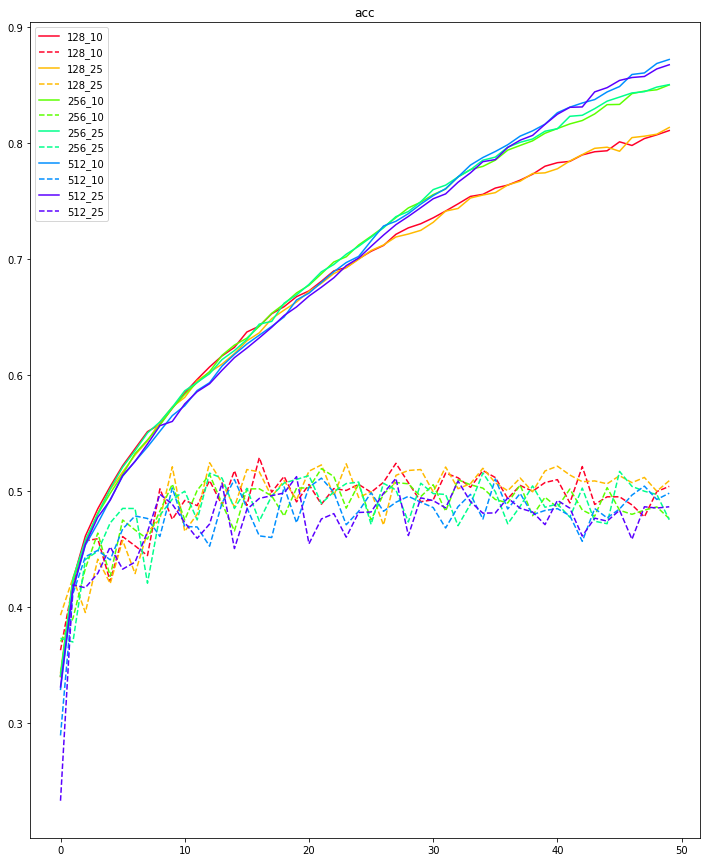

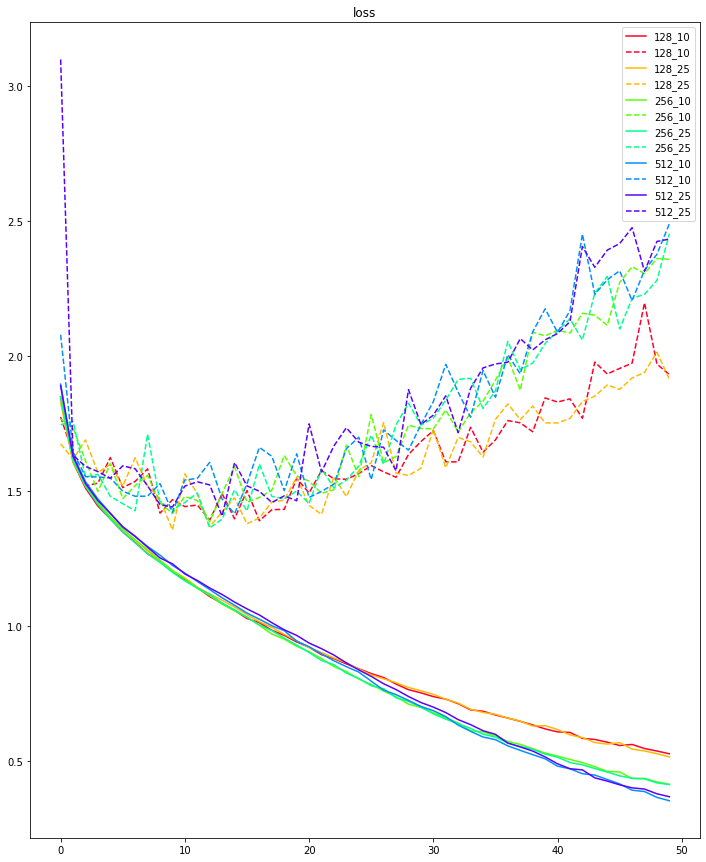

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

cm = plt.get_cmap("gist_rainbow")
colorArray = [ cm(1.0 * i/len(permutationArray)) for i in range(len(permutationArray))]


plt.figure(figsize=(12,15))
for idx, name in enumerate(permutationArray):
    plt.plot(range(EPOCH), results[name]["acc"], "-", label=name, c=colorArray[idx])
    plt.plot(range(EPOCH), results[name]["val_acc"], "--", label=name, c=colorArray[idx])
plt.title("acc")
plt.legend()
plt.show()


plt.figure(figsize=(12,15))
for idx, name in enumerate(permutationArray):
    plt.plot(range(EPOCH), results[name]["loss"], "-", label=name, c=colorArray[idx])
    plt.plot(range(EPOCH), results[name]["val_loss"], "--", label=name, c=colorArray[idx])
plt.title("loss")
plt.legend()
plt.show()

In [61]:
jsonString = model.to_json()
test_model = keras.models.model_from_json(jsonString)
test_model.load_weights("./512_10_best_weights")
pred = test_model.predict(x_test)
acc = keras.metrics.categorical_accuracy(y_test, pred)

print(f"預測的準確率：{acc}")

預測的準確率：[1. 1. 1. ... 0. 0. 1.]
